In [7]:
#importing all the necessary libraries
import cv2
import pandas as pd
import numpy as np
import sklearn
import warnings
import sys
import os
DeprecationWarning('ignore')
os.chdir('D:/machine_learning/trainset')
warnings.filterwarnings('ignore')

In [8]:
#importing Pytorvh modules
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cpu


In [9]:
#importing PIL image as it is much more convinient and compatible with pytoch
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display

In [10]:
reference_images=[]#reference images
selfies=[]#selfie of employees followed by _script
n_sub=0

In [11]:
PATH='D:/machine_learning/trainset'
for folder in os.listdir(PATH):
    n_sub=n_sub+1
    #img_dir=os.path.join(subfolder,sub)
    for img_raw in os.listdir(folder):
        if 'script' in img_raw:
            reference_images.append(img_raw)
            
        else :
            selfies.append(img_raw)

In [12]:
print("The total number of Folders in dataset : ",len(os.listdir(PATH)))
print("The total number of Employee in dataset : ",n_sub)
print("The total number of selfies are : ",len(selfies))
print("The total number of script images are : ",len(reference_images))

The total number of Folders in dataset :  1012
The total number of Employee in dataset :  1012
The total number of selfies are :  3198
The total number of script images are :  1221


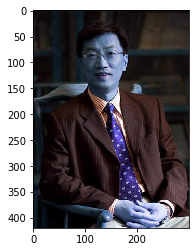

In [13]:
image=cv2.imread('D:/machine_learning/trainset/0003_0000345/0000002.jpg')
plt.imshow(image)
plt.show()

In [14]:
dataset_path = 'D:/machine_learning/trainset'

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=40),

    transforms.Resize(300),
    transforms.CenterCrop(256),

    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)#extracting the dataset set inwhich the functions to be performed
print(dataset)


Dataset ImageFolder
    Number of datapoints: 4419
    Root location: D:/machine_learning/trainset
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.3)
               RandomRotation(degrees=[-40.0, 40.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=300, interpolation=bilinear)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
           )


In [15]:
import pathlib
root=pathlib.Path(PATH)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [16]:
print(classes) #list contains all the labels i.e employee unique id

['0001_0000255', '0001_0000262', '0001_0000264', '0001_0000265', '0001_0000268', '0001_0000274', '0001_0000278', '0001_0000281', '0001_0000283', '0001_0000284', '0001_0000286', '0001_0000292', '0001_0000293', '0001_0000297', '0001_0000298', '0001_0000299', '0001_0000301', '0001_0000303', '0001_0000304', '0001_0000305', '0002_0000307', '0002_0000308', '0002_0000313', '0002_0000324', '0003_0000329', '0003_0000339', '0003_0000343', '0003_0000344', '0003_0000345', '0003_0000347', '0003_0000348', '0003_0000353', '0003_0000354', '0003_0000356', '0003_0000359', '0003_0000360', '0003_0000361', '0003_0000362', '0003_0000371', '0003_0000372', '0003_0000375', '0003_0000386', '0003_0000390', '0003_0000392', '0005_0000437', '0005_0000439', '0005_0000449', '0005_0000450', '0005_0000451', '0005_0000452', '0005_0000455', '0005_0000463', '0005_0000464', '0005_0000475', '0005_0000478', '0005_0000486', '0005_0000487', '0005_0000497', '0005_0000503', '0005_0000509', '0005_0000510', '0005_0000512', '0005_0

In [11]:
print(len(classes))

1012


In [17]:
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
# Split the dataset into train & test containing 3000 and 1419 images respectively.
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (3000,1419))

# Create a Train DataLoader using Train Dataset
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)
# Create a Test DataLoader using Test Dataset
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

In [18]:
figsize = (16,16)#plotting images that is present in our dataset

def PlotSamples(dataloader, title='Images'):
    sample_data = next(iter(dataloader))[0].to(device)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        sample_data, padding=2, normalize=True
    ).cpu(), (1,2,0)))
    
    
def PlotClass(dataloader, mclass, title='Images', num=64):
    ret = []
    
    for data in dataloader.dataset:
        if data[1] == mclass:
            ret.append(data[0])
            
            if len(ret) == num:
                break
    
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        ret, padding=2, normalize=True
    ).cpu(), (1,2,0)))
    

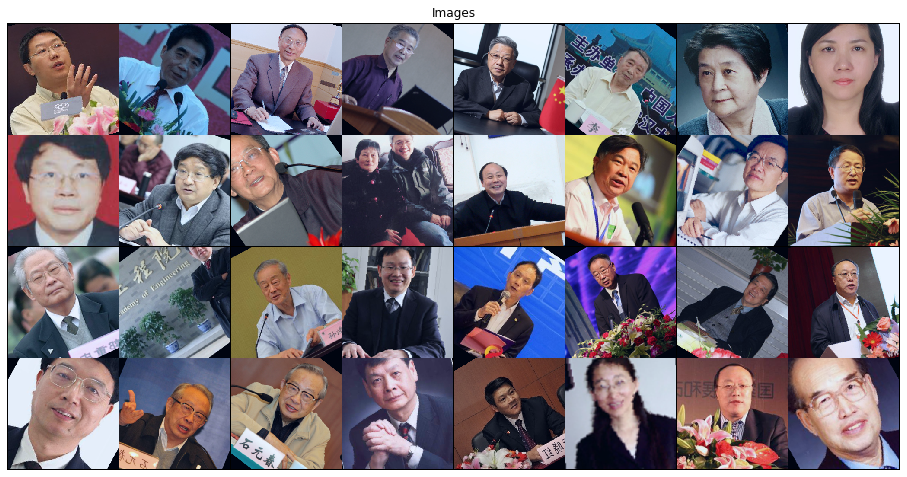

In [13]:
PlotSamples(train_dataloader)#printing our train dataset images

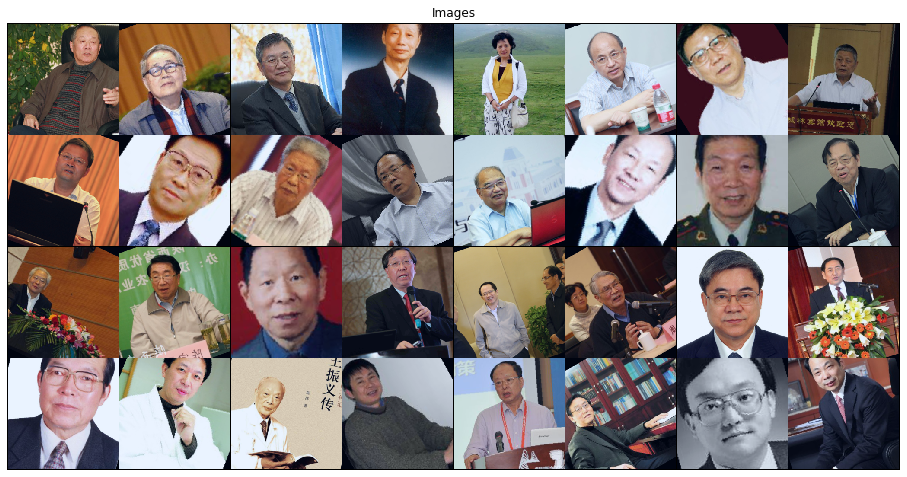

In [14]:
PlotSamples(test_dataloader)

In [19]:
class MyModel(nn.Module):#our CNN model from scratch
    def __init__(self,num_classes=1012):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3), nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

        ).to(device)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(4096,3000),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(3000,1500),
           
            nn.Dropout(0.5),
            nn.Linear(1500,1012)
            
        ).to(device)
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x

print(MyModel())
model = MyModel(num_classes=1012).to(device)
summary(model, (3,256,256))

MyModel(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (16): ReLU()
    (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (18): ReLU()
    (19): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (20): Conv2d(128

In [15]:
def Train(epoch, print_every=20):#our training dataset
    total_loss = 0
    start_time = time()
    
    accuracy = []
    
    for i, batch in enumerate(train_dataloader,1):
        minput = batch[0].to(device)  # Get batch of images from our train dataloader
        target = batch[1].to(device)# Get the corresponding target(0, 1 or 2) representing eaxh employee
        
        moutput = model(minput)  # output by our model
       
        loss = criterion(moutput, target) #compute entropy loss
        total_loss += loss.item()
        #print(total_loss)
        optimizer.zero_grad()# Clear the gradients if exists as gradient are used for back propagation 
        loss.backward() # Back propogate the losses
        optimizer.step()#update the losses
        _,prediction=torch.max(moutput.data,1)
                     
        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item()) 
        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time 
            ))
    
    return total_loss / len(train_dataloader) # Returning Average Training Loss

In [16]:
def Test(epoch):
    total_loss = 0
    start_time = time()

    accuracy = []
    
    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(test_dataloader):
            minput = batch[0].to(device)
            target = batch[1].to(device)
            moutput = model(minput)

            loss = criterion(moutput, target) 
            total_loss += loss.item()
        
            argmax = moutput.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)
            accuracy.append((target==argmax).sum().item()) # Find the accuracy of the batch by comparing it with actual targets
            
    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))
    return total_loss/len(test_dataloader) # Returning Average Testing Loss

In [17]:
lr = 0.001
model = MyModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [20]:
import math
def compare(x,y,x1,y1):
    if(x!=y):
        print("match")
        print(" confidence ",math.sqrt(int(int(x1)*int(y1)))+65,"%")
    else:
        print("no_match","  confidence ", math.sqrt(int(int(x1)*int(y1))),"%")

In [ ]:
Test(0)

train_loss = []
test_loss = []

for epoch in range(1, 51):
    train_loss.append(Train(epoch,20))
    test_loss.append(Test(epoch))

    print('\n')
    
    if epoch % 10 == 0:
        torch.save(model, 'model_'+str(epoch)+'.pth')

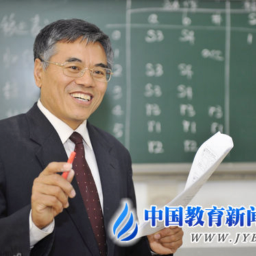

In [21]:
denormalize = transforms.Compose([
    transforms.Normalize(mean = -mean/std, std = 1./std),
    transforms.ToPILImage()
])


with torch.no_grad():
        #PATH='D:/machine_learning/trainset/0001_0000292/0000002.jpg'
        im = cv2.imread('D:/machine_learning/trainset/0001_0000292/0000002.jpg')#taking our normal image which  is a selfie
        img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(img)#converting it inti PIL image
        
        image = transforms.Compose([
            transforms.Resize(256),  
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])(image)#applying some transformations in the image

        image_tensor = image.view(1,3,256,256).to(device)

        moutput = model(image_tensor)
        moutput = nn.Softmax(dim=1)(moutput)[0]*100# output generating the targer
        
        idx = moutput.argmax().data.item()
        oclass = list(classes)[idx]#finding the id of the employee through classes list
        moutput = moutput.int().data.cpu().numpy()

        display(denormalize(image))
        #print(oclass, ':', moutput[idx], '%', '\n\n')

model.train()
pass

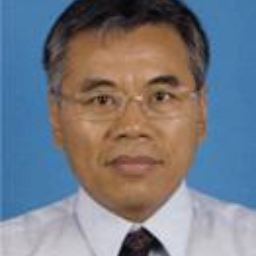

In [22]:
with torch.no_grad():
        PATH2='D:/machine_learning/trainset/0001_0000292/0001_0000292_script.jpg'
        im = cv2.imread('D:/machine_learning/trainset/0001_0000292/0001_0000292_script.jpg')# INPUT 2 passportsize photograph input
        img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(img)
        
        image = transforms.Compose([
            transforms.Resize(256),  
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])(image)

        image_tensor = image.view(1,3,256,256).to(device)

        moutput = model(image_tensor)
        moutput = nn.Softmax(dim=1)(moutput)[0]*100
        
        idx = moutput.argmax().data.item()
        oclass1 = list(classes)[idx]# finding the employee it belongs to
        moutput1 = moutput.int().data.cpu().numpy()

        display(denormalize(image))
        #print(oclass1, ':', moutput1[idx], '%', '\n\n')

model.train()
pass

In [23]:
compare(oclass,moutput[idx], oclass1,moutput1[idx])

match
 confidence  65.0 %
